# Build a brain model for decilitated cell

In [1]:
from brian2 import *
from brian2tools import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [2]:
import numpy as np
import pandas as pd

In [3]:
dt = 5e-05 * second
dt

50. * usecond

## Load the data

In [4]:
df_v = pd.read_csv('decilliated_v_pos.csv')
df_ic = pd.read_csv('decilliated_ic_pos.csv')
df_inoise = pd.read_csv('decilliated_i_noise.csv')
df_wn_v = pd.read_csv('decilliated_v_noise.csv')

#### Get V positive

In [5]:
Vout = df_v.to_numpy()
Vout = Vout[:, 2:]

In [6]:
np.shape(Vout)

(20, 22400)

In [7]:
Vout

array([[-0.02864093, -0.02855869, -0.02865738, ..., -0.02867383,
        -0.02862449, -0.02865738],
       [-0.02885476, -0.02873963, -0.02862449, ..., -0.02609142,
        -0.0263217 , -0.02602562],
       [-0.02819682, -0.02829552, -0.02832841, ..., -0.02829552,
        -0.02827907, -0.02844355],
       ...,
       [-0.02579534, -0.02564731, -0.02572955, ..., -0.02423274,
        -0.02424918, -0.02433143],
       [-0.02441367, -0.02439722, -0.02418339, ..., -0.02276882,
        -0.02257144, -0.02270302],
       [-0.021272  , -0.02135425, -0.02138714, ..., -0.02329517,
        -0.02314713, -0.02311424]])

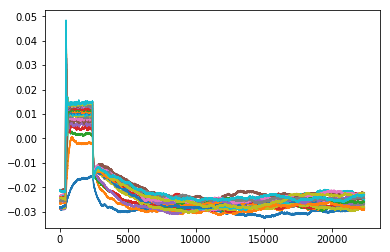

In [8]:
plot(Vout.transpose());

#### Get positive injection current

In [9]:
Ic = df_ic.to_numpy()
Ic = Ic[:, 1:]

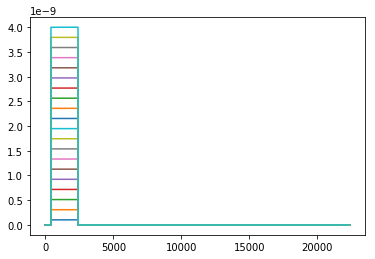

In [10]:
plot(Ic.transpose());

#### Get white noise injection

In [11]:
Inoise = df_inoise.to_numpy()
Inoise = Inoise[:, 1:].transpose()[0]

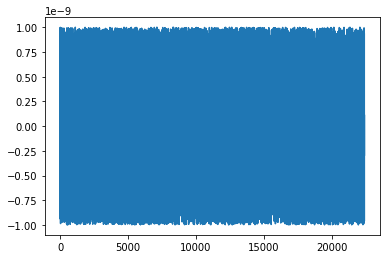

In [12]:
plot(Inoise);

#### Get V from white noise

In [13]:
Vnoise = df_wn_v.to_numpy()
Vnoise = Vnoise[:, 1:].transpose()[0]

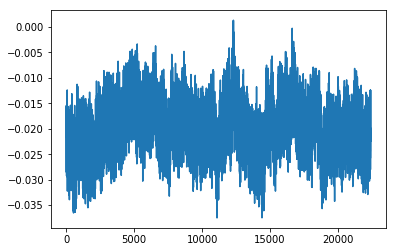

In [14]:
plot(Vnoise);

### Concatinate the data

In [15]:
np.shape(Vnoise)

(22400,)

In [16]:
np.shape(Vout)

(20, 22400)

In [17]:
output = np.concatenate((Vout, [Vnoise]))
np.shape(output)

(21, 22400)

In [18]:
input_cur = np.concatenate((Ic, [Inoise]))
np.shape(input_cur)

(21, 22400)

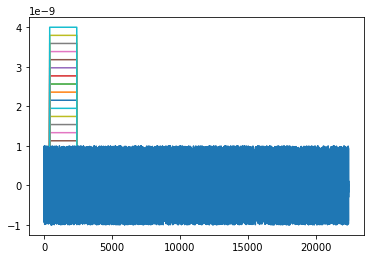

In [19]:
plot(input_cur.transpose());

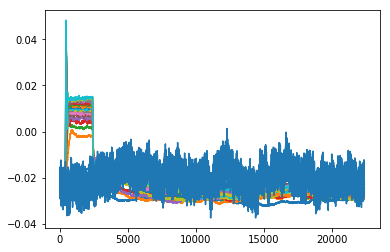

In [20]:
plot(output.transpose());

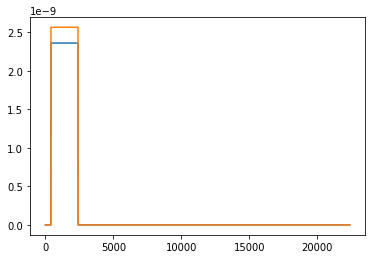

In [21]:
plot(input_cur[11:13].transpose())

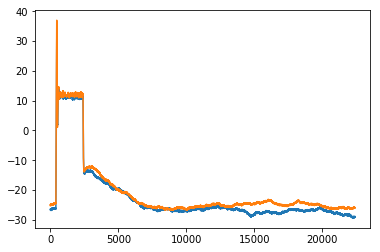

In [22]:
plot((output[11:13]/1e-3).transpose());

## Build a model

In [23]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*n*(Ek - v) + I(t))/C : volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
''',
# C = 130*pF,
C = 300*pF,
EL = -30*mV,
gL = 1/50*1/Mohm)
# gL = 1/142*1/Mohm)

In [24]:
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
I = TimedArray(input_current0, dt=dt)

In [25]:
G = NeuronGroup(1, model, method='exponential_euler')
G.set_states({'g_k': 1, 'kn': 1, 'taun': 1, 'Vn': 1, 'Ek': 1}, units=False)
run(10*ms)

In [26]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*(n**4)*(Ek - v) + I)/C : volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
''',
C = 300*pF,
EL = -30*mV,
gL = 1/50*1/Mohm)

In [27]:
start_scope()
n_opt = NevergradOptimizer(method='DE')
# n_opt = SkoptOptimizer()
metric = MSEMetric()

res, error = fit_traces(model=model, input_var='I', output_var='v',
                        input=input_cur[11:13] * amp, output=output[11:13]/1e-3 * volt, dt=dt,
                        method='exponential_euler',
                        g_k=[10e-3*siemens, 10e2*siemens],
                        kn = [5*mV, 20*mV],
                        Vn = [-20*mV, 20*mV],
                        Ek = [-100*mV, 0*mV],
                        taun=[10e-2*ms, 100*ms],
                        param_init={'v': -30 * mV},
                        n_rounds=1, n_samples=30, optimizer=n_opt, metric=None)

round 0 with error 566.5046057246732
parameters: {'g_k': 784.0268778433034, 'Vn': -0.01205784693955246, 'Ek': -0.082414687517431, 'taun': 0.034681501976835644, 'kn': 0.01742118752379391}


In [28]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*(n**4)*(Ek - v) + I)/C : volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
C: farad (constant)
EL: volt (constant)
gL: siemens (constant)
''',
# C = 300*pF,
# EL = -30*mV,
# gL = 1/50*1/Mohm
)

In [92]:
start_scope()
n_opt = NevergradOptimizer(method='DE')
# n_opt = SkoptOptimizer()
metric = MSEMetric()


In [93]:
def callback(res, errors, parameters, index):
    print('index {} errors minimum: {}'.format(index, min(errors)) )

In [94]:
# set_device('cpp_standalone', directory='parallel', clean=False)

In [106]:
res, error = fit_traces(model=model, input_var='I', output_var='v',
                        input=input_cur * amp, output=output/1e-3 * volt, dt=dt,
                        method='exponential_euler',
                        callback=callback,
                        EL=[-50*mV, -10*mV],
                        C=[100*pF, 400*pF],
                        gL=[7*nS, 20*nS],                        
                        kn=[5*mV, 20*mV],
                        Vn=[-20*mV, 20*mV],
                        Ek=[-100*mV, 0*mV],
                        g_k=[1e1*uS, 1e6*uS],
                        taun=[0.1*ms, 30*ms],
                        param_init={'v': -30 * mV},
                        n_rounds=40, n_samples=30, optimizer=n_opt, metric=None)

index 0 errors minimum: 584.0094856036651
index 1 errors minimum: 583.6793834424633
index 2 errors minimum: 583.5195512378236
index 3 errors minimum: 583.4279994769464
index 4 errors minimum: 583.3128894118254
index 5 errors minimum: 583.302906427247
index 6 errors minimum: 583.2836107962344
index 7 errors minimum: 583.2623938470149
index 8 errors minimum: 583.2090022928644
index 9 errors minimum: 583.184616697276
index 10 errors minimum: 583.1719811410604
index 11 errors minimum: 583.1513724188078
index 12 errors minimum: 583.1624246658142
index 13 errors minimum: 583.157884292377
index 14 errors minimum: 583.1542957581311
index 15 errors minimum: 583.1508939800505
index 16 errors minimum: 583.1582486996698
index 17 errors minimum: 583.1562048765834
index 18 errors minimum: 583.1430712398994
index 19 errors minimum: 583.1387635277591
index 20 errors minimum: 583.1488311501458
index 21 errors minimum: 583.1473778338668
index 22 errors minimum: 583.1444420630427
index 23 errors minimum:

In [107]:
res

{'EL': -0.04596971547099493,
 'g_k': 0.9589134043842433,
 'Vn': -0.018315562846225274,
 'Ek': -0.09865263102703573,
 'taun': 0.0032405379517334004,
 'gL': 7.382393869320427e-09,
 'kn': 0.01961200730616921,
 'C': 3.7626785406468376e-10}

In [108]:
print('g_k', res['g_k']*siemens)

g_k 0.9589134 S


In [109]:
print('taun', res['taun']*second)

taun 3.24053795 ms


In [110]:
print('Ek', res['Ek']*volt)
print('C', res['C']*farad)
print('EL', res['EL']*volt)
print('gL', res['gL']*siemens)
print('Vn', res['Vn']*volt)
print('kn', res['kn']*volt)

Ek -98.65263103 mV
C 0.37626785 nF
EL -45.96971547 mV
gL 7.38239387 nS
Vn -18.31556285 mV
kn 19.61200731 mV


In [111]:
# visualization of the results
start_scope()
fits = generate_fits(model=model, method='exponential_euler', params=res,
                     input=input_cur * amp, input_var='I', output_var='v',
                     param_init={'v': -92 * mV},
                     dt=dt)

fits/mV

array([[-92.        , -91.95486632, -91.90977708, ..., -95.6975221 ,
        -95.6975221 , -95.6975221 ],
       [-92.        , -91.95486632, -91.90977708, ..., -95.6975221 ,
        -95.6975221 , -95.6975221 ],
       [-92.        , -91.95486632, -91.90977708, ..., -95.6975221 ,
        -95.6975221 , -95.6975221 ],
       ...,
       [-92.        , -91.95486632, -91.90977708, ..., -95.6975221 ,
        -95.6975221 , -95.6975221 ],
       [-92.        , -91.95486632, -91.90977708, ..., -95.6975221 ,
        -95.6975221 , -95.6975221 ],
       [-92.        , -91.8434459 , -91.7288823 , ..., -95.40069121,
        -95.49817124, -95.53549581]])

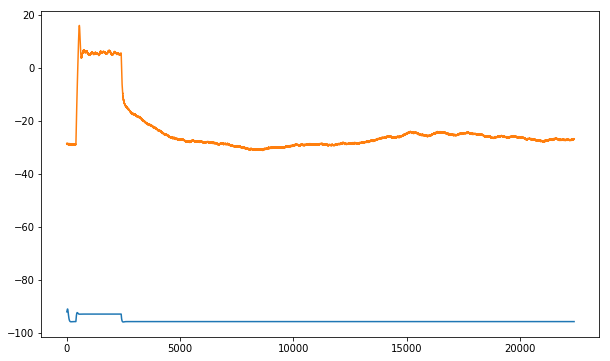

In [112]:
d = 4
plt.figure(figsize=(10,6))
plot(fits[d]/mV)
plot(output[d]/1e-3);

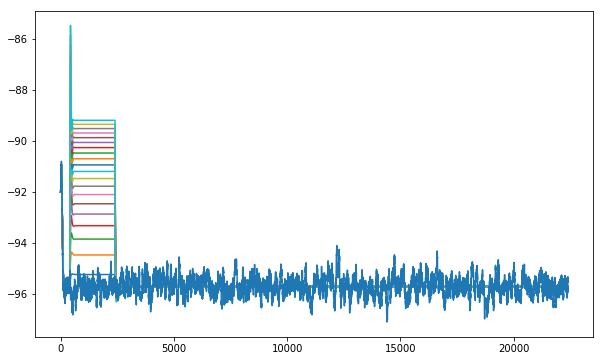

In [113]:
plt.figure(figsize=(10,6))
plot((fits/mV).transpose());

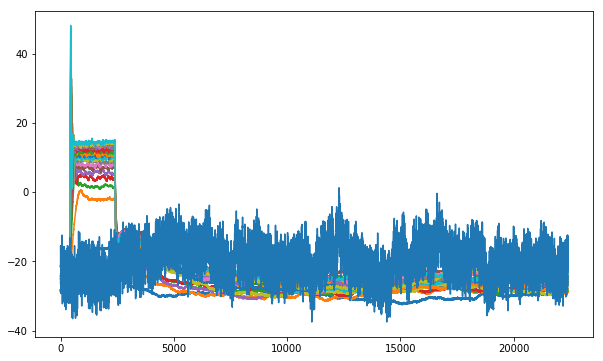

In [114]:
plt.figure(figsize=(10,6))
plot((output/1e-3).transpose());

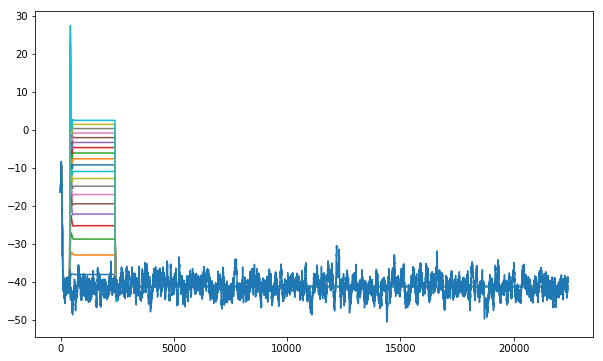

In [115]:
plt.figure(figsize=(10,6))
plot((fits/mV*6.7+600).transpose());

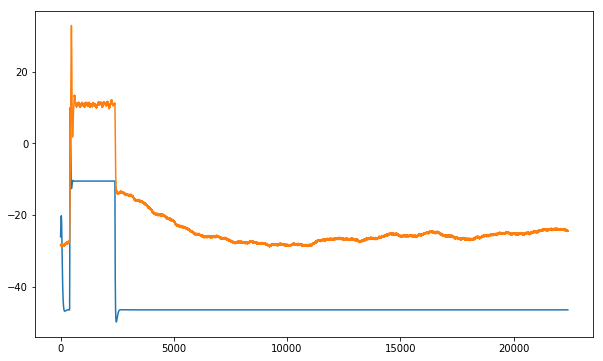

In [116]:
plt.figure(figsize=(10,6))
plot((fits[19]/mV*5.5+480).transpose());
plot((output[10]/1e-3).transpose());